In [1]:
!nvidia-smi

Thu Oct 18 18:00:20 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:0B:00.0 Off |                  N/A |
| 26%   49C    P0    59W / 250W |      2MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:41:00.0  On |                  N/A |
| 37%   63C    P0    62W / 250W |    760MiB / 12188MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from itertools import cycle, count
from textwrap import wrap

import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import time
import json
import sys
import gym
import io

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

plt.style.use('fivethirtyeight')
np.set_printoptions(suppress=True)

%matplotlib inline

In [3]:
torch.cuda.is_available()

True

In [4]:
def make_monitored_env(env_name, monitor_mode, seed):
    mdir = tempfile.mkdtemp()
    env = gym.make(env_name)
    env = wrappers.Monitor(env, mdir, force=True, mode=monitor_mode)
    env.seed(seed)
    return env

In [5]:
def plot_results(results, log_scale=False):
    plt.figure(figsize=(15, 10))
    lines = ["-","--",":","-."]
    linecycler = cycle(lines)
    for experiment, experiment_name in results:
        label = '\n'.join(wrap(experiment_name.replace('_', ', '), 50))
        plt.plot(experiment, next(linecycler), label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if log_scale: plt.xscale('log')
    plt.ylabel('Rewards')
    plt.xlabel('Episode')
    plt.show()

In [6]:
def get_videos_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [7]:
def get_gif_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [8]:
class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32).unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [9]:
class FCDuelingQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCDuelingQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_value = nn.Linear(hidden_dims[-1], 1)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32).unsqueeze(0)      
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        v = self.output_value(x)
        a = self.output_layer(x)
        q = v.expand_as(a) + (a - a.mean(1, keepdim=True).expand_as(a))
        return q

    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable

    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [10]:
class ReplayBuffer():
    def __init__(self, max_samples=100000, batch_size=32):
        self.memory = deque(maxlen=max_samples)
        self.batch_size = batch_size

    def store(self, sample):
        self.memory.append(sample)

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        idxs = np.random.choice(len(self.memory), batch_size)
        samples = np.array([self.memory[idx] for idx in idxs])
        batches = [np.vstack(batch_type) for batch_type in samples.T]
        return batches
    
    def is_prioritized(self):
        return False

    def __len__(self):
        return len(self.memory)

In [11]:
class PrioritizedReplayBuffer():
    def __init__(self, max_samples=100000, batch_size=32, rank_based=True, 
                 alpha=0.7, beta0=0.5, beta_rate=0.999965, epsilon=0.001):
        self.max_samples = max_samples
        self.memory = np.empty(shape=(self.max_samples, 2), dtype=np.ndarray)
        self.batch_size = batch_size
        self.n_entries = 0
        self.next_index = 0
        self.td_error_index = 0
        self.sample_index = 1
        self.rank_based = rank_based # if not rank_based, then proportional
        self.alpha = alpha # how much prioritization to use 0 is uniform (no priority), 1 is full priority
        self.beta = beta0 # bias correction 0 is no correction 1 is full correction
        self.beta0 = beta0 # beta0 is just beta's initial value
        self.beta_rate = beta_rate
        self.epsilon = epsilon

    def update(self, idxs, td_errors):
        self.memory[idxs, self.td_error_index] = np.abs(td_errors)
        if self.rank_based:
            sorted_arg = self.memory[:self.n_entries, self.td_error_index].argsort()[::-1]
            self.memory[:self.n_entries] = self.memory[sorted_arg]

    def store(self, sample):
        priority = self.memory[:self.n_entries, self.td_error_index].max() if self.n_entries > 0 else 1.0
        self.memory[self.next_index, self.td_error_index] = priority
        self.memory[self.next_index, self.sample_index] = np.array(sample)
        self.n_entries = min(self.n_entries + 1, self.max_samples)
        self.next_index += 1
        self.next_index = self.next_index % self.max_samples

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        self.beta = min(1.0, self.beta * self.beta_rate**-1)
        entries = self.memory[:self.n_entries]

        if self.rank_based:
            priorities = 1/(np.arange(self.n_entries) + 1)
        else: # proportional
            priorities = entries[:, self.td_error_index] + self.epsilon
        scaled_priorities = priorities**self.alpha        
        probs = np.array(scaled_priorities/np.sum(scaled_priorities), dtype=np.float64)

        weights = (1.0/self.n_entries * 1.0/probs)**self.beta
        normalized_weights = weights/weights.max()
        idxs = np.random.choice(self.n_entries, batch_size, replace=False, p=probs)
        samples = np.array([entries[idx] for idx in idxs])
        
        samples_stacks = [np.vstack(batch_type) for batch_type in np.vstack(samples[:, self.sample_index]).T]
        idxs_stack = np.vstack(idxs)
        weights_stack = np.vstack(normalized_weights[idxs])
        return idxs_stack, weights_stack, samples_stacks

    def is_prioritized(self):
        return True

    def __len__(self):
        return self.n_entries
    
    def __repr__(self):
        return str(self.memory[:self.n_entries])
    
    def __str__(self):
        return str(self.memory[:self.n_entries])

In [12]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, model, state):
        model.eval()

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            return np.argmax(q_values)

In [13]:
class EGreedyLinearStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=0.995, min_epsilon=0.01):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()

        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.epsilon = max(self.min_epsilon, self.decay_rate*self.epsilon)
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [14]:
class EGreedyDecayStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=1e-5, min_epsilon=0.1):
        self.t = 0
        self.init_epsilon = init_epsilon
        self.epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()
        
        self.exploratory_action_taken = False
        self.epsilon = max(self.init_epsilon * np.exp(-self.decay_rate * self.t), 
                           self.min_epsilon)
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.t += 1
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [15]:
class StaircaseStrategy():
    def __init__(self, staircase):
        self.t = 0
        self.index = 0
        self.epsilon = list(staircase.keys())[self.index]
        self.staircase = staircase
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()
        
        self.exploratory_action_taken = False
        if list(self.staircase.values())[self.index] and self.t > list(self.staircase.values())[self.index]:
            self.index += 1
            self.epsilon = list(self.staircase.keys())[self.index]
            self.t = 0

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.t += 1
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [16]:
class SoftMaxStrategy():
    def __init__(self, init_temp=1.0, min_temp=0.1, exploration_ratio=0.9, max_steps=20000):
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_steps = max_steps
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        model.eval()
        
        self.exploratory_action_taken = False
        temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            scaled_qs = q_values/temp
            norm_qs = scaled_qs - scaled_qs.max()            
            e = np.exp(norm_qs)
            probs = e / np.sum(e)
            assert np.isclose(probs.sum(), 1.0)

        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]
        self.t += 1
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [17]:
class DQNAgent():
    def __init__(self, buffer, model, optimizer, optimizer_lr, strategy, 
                 update_target_every_timesteps, train_every_timesteps, 
                 double_learning_enabled, tau, max_gradient, n_warmup_batch, 
                 print_every_episodes=25, save_every_episodes=500,
                 experiment_name='default', random_seed=12345):

        self.buffer = buffer()
        self.model_fn = model
        self.optimizer_fn = optimizer
        self.optimizer_lr = optimizer_lr
        self.strategy = strategy()
        self.update_target_every_timesteps = update_target_every_timesteps
        self.train_every_timesteps = train_every_timesteps
        self.double_learning_enabled = double_learning_enabled
        self.tau = tau
        self.max_gradient = max_gradient
        self.n_warmup_batch = n_warmup_batch
        self.print_every_episodes = print_every_episodes
        self.save_every_episodes = save_every_episodes
        self.experiment_name = experiment_name
        self.random_seed = random_seed

    def optimize_model(self, experiences):
        self.model.train()

        if self.buffer.is_prioritized():
            idxs, weights, (states, actions, rewards, next_states, is_terminals) = experiences
        else:
            states, actions, rewards, next_states, is_terminals = experiences
            weights, idxs = np.ones_like(rewards), None
        weights = self.model.numpy_float_to_device(weights)
        batch_size = len(is_terminals)
        
        if self.double_learning_enabled:
            argmax_a_q_sp = self.model(next_states).detach().max(1)[1]
        else:
            argmax_a_q_sp = self.target(next_states).detach().max(1)[1]

        q_sp = self.target(next_states).detach()
        max_a_q_sp = q_sp[np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_s = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.model(states).gather(1, actions)

        td_errors = q_sa - target_q_s
        loss = (weights * td_errors).pow(2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-self.max_gradient, 
                                   self.max_gradient)
        self.optimizer.step()

        if self.buffer.is_prioritized():
            priorities = np.abs(td_errors.cpu().detach().numpy())
            self.buffer.update(idxs, priorities)
        
        
    def interaction_step(self, env, state):
        action = self.strategy.select_action(self.model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        experience = (state, action, reward, new_state, float(is_terminal))
        self.buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.strategy.exploratory_action_taken)
        return new_state, is_terminal

    def train(self, env, gamma, max_episodes, max_mean_reward):
        self.gamma = gamma
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_exploration = []
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        
        self.model = self.model_fn(nS, nA)
        self.model.eval()
        self.target = self.model_fn(nS, nA)
        self.target.eval()
        self.optimizer = self.optimizer_fn(self.model, self.optimizer_lr)
        
        for episode in range(1, max_episodes + 1):
            start = time.time()
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for timestep in count(start=1):
                state, is_terminal = self.interaction_step(env, state)
                
                if len(self.buffer) > self.buffer.batch_size * self.n_warmup_batch:
                    experiences = self.buffer.sample()

                    if self.buffer.is_prioritized():
                        idxs, weights, samples = experiences
                        experiences = self.model.load_experiences(samples)
                        experiences = (idxs, weights) + (experiences,)
                    else:
                        experiences = self.model.load_experiences(experiences)
                
                    if np.sum(self.episode_timestep) % self.train_every_timesteps == 0:
                        self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_timesteps == 0:
                    for target, network in zip(self.target.parameters(), 
                                               self.model.parameters()):
                        mixed_weights = (1.0 - self.tau) * target.data + self.tau * network.data
                        target.data.copy_(mixed_weights)
                        
                if is_terminal:
                    break
            
            self.episode_seconds.append(time.time() - start)
            mean_seconds = np.mean(self.episode_seconds[-100:])
            mean_reward = np.mean(self.episode_reward[-100:])
            mean_10_reward = np.mean(self.episode_reward[-25:])
            if episode % self.print_every_episodes == 0 or mean_reward >= max_mean_reward:
                episode_exploration_ratio = self.episode_exploration[-1] / self.episode_timestep[-1]
                debug_message = 'ep {:03}, tmstps {:05}, explr rat {:.2f}, buf sze {:05}, '
                debug_message += '25/100 ep av rew {:.2f}/{:.2f}, 100 ep av sec {:.2f}'
                debug_message = debug_message.format(
                    episode, int(np.sum(self.episode_timestep)), 
                    episode_exploration_ratio, len(self.buffer), 
                    mean_10_reward, mean_reward, mean_seconds)
                print(debug_message)

            if episode % self.save_every_episodes == 0 or mean_reward >= max_mean_reward:
                directory_name =  os.path.join('checkpoints', experiment_name.replace('_', '/'))
                filename = '{}_{}_{}.ckp'.format(episode, timestep, mean_reward)
                file_path =  os.path.join(directory_name, filename)
                if not os.path.exists(directory_name):
                    os.makedirs(directory_name)
                torch.save(self.model.state_dict(), file_path)

            if mean_reward >= max_mean_reward:
                print('Training complete')
                break

        env.close()
        return self.episode_reward

    
    def evaluate(self, env, strategy, episodes=10, render=True):
        rewards = []
        for episode in range(episodes):
            state, is_terminal = env.reset(), False
            rewards.append(0)
            for t in count(start=1):
                if render: env.render()
                action = strategy.select_action(self.model, state)
                state, reward, is_terminal, _ = env.step(action)
                rewards[-1] += reward
                if is_terminal:
                    break

        env.close()
        return rewards

In [18]:
training_env_name, testing_env_name = 'CartPole-v0', 'CartPole-v1'
buffers = {
    'prioritized-proportional': lambda: PrioritizedReplayBuffer(
        max_samples=20000, batch_size=32, rank_based=False, 
        alpha=0.5, beta0=0.4, beta_rate=0.99998, epsilon=0.001),
    'prioritized-ranked': lambda: PrioritizedReplayBuffer(
        max_samples=50000, batch_size=32, rank_based=True, 
        alpha=0.5, beta0=0.4, beta_rate=0.99998, epsilon=0.001),
    'uniform': lambda: ReplayBuffer(
        max_samples=20000, batch_size=32),
}

models = {
    'dueling' : lambda nS, nA: FCDuelingQ(
        nS, nA, hidden_dims=(64,64)),
    'vanilla': lambda nS, nA: FCQ(
        nS, nA, hidden_dims=(64,64)),
}

optimizers = {
    'rmsprop': lambda net, lr: optim.RMSprop(
        net.parameters(), lr=lr),
    #'adam': lambda net, lr: optim.Adam(
    #    net.parameters(), lr=lr), 
}

strategies = {
    'softmax': lambda: SoftMaxStrategy(
        init_temp=1.0, min_temp=0.2, exploration_ratio=1.0, max_steps=50000),
    #'staircase': lambda: StaircaseStrategy(
    #    staircase={1.0:1000, 0.5:3000, 0.25:5000, 0.15:5000, 0.1:None}),
    #'egreedyexponential': lambda: EGreedyLinearStrategy(
    #    init_epsilon=1.0, decay_rate=0.998, min_epsilon=0.1),
    #'egreedylinear': lambda: EGreedyLinearStrategy(
    #    init_epsilon=1.0, decay_rate=0.998, min_epsilon=0.1),
}

optimizer_lrs = [
    #0.0005,
    0.001,
]
train_every_timestepss = [
    2,
    # 5,
]
enable_double_learning = [
    True,
    False,
]
target_update_pairs = [
    {'every_timesteps': 4, 'tau': 0.05}, 
    #{'every_timesteps':20, 'tau':1.0},
]
max_gradients = [
    #1,
    8,
    #float('inf'),
]
n_warmup_batches = [
    #1,
    #2,
    5,
    #10,
]
random_seeds = [
    12345, 
    67890,
]
gamma, max_episodes, max_mean_reward = 1.0, 500, 200
print_every_episodes, save_every_episodes = 25, 500

BestEnv = namedtuple('best_env', 
                     ['experiment_name', 
                      'env', 
                      'mean_reward', 
                      'num_episodes'])
best_training_env = BestEnv(experiment_name='', 
                            env=None, 
                            mean_reward=float('-inf'), 
                            num_episodes=float('inf'))
best_evaluation_env = BestEnv(experiment_name='', 
                              env=None, 
                              mean_reward=float('-inf'), 
                              num_episodes=float('inf'))

training_results, evaluation_results = [], []
successful_experiments = []
for n_warmup_batch in n_warmup_batches:
    print('n_warmup_batch={}'.format(n_warmup_batch))
    for strategy in strategies:
        print('\tstrategy={}'.format(strategy))
        for buffer in buffers:
            print('\t\tbuffer={}'.format(buffer))
            for double_learning_enabled in enable_double_learning:
                print('\t\t\tdouble_learning_enabled={}'.format(double_learning_enabled))
                for train_every_timesteps in train_every_timestepss:
                    print('\t\t\t\ttrain_every_timesteps={}'.format(train_every_timesteps))
                    for target_update_pair in target_update_pairs:
                        print('\t\t\t\t\ttarget_update_pair={}'.format(target_update_pair))
                        for max_gradient in max_gradients:
                            print('\t\t\t\t\t\tmax_gradient={}'.format(max_gradient))
                            for model in models:
                                print('\t\t\t\t\t\t\tmodel={}'.format(model))
                                for optimizer in optimizers:
                                    print('\t\t\t\t\t\t\t\toptimizer={}'.format(optimizer))
                                    for optimizer_lr in optimizer_lrs:
                                        print('\t\t\t\t\t\t\t\t\toptimizer_lr={}'.format(optimizer_lr))
                                        experiment_name = ''
                                        experiment_name += '{}_{}_{}-{}_{}'
                                        experiment_name += '_target-update-pair-{}'
                                        experiment_name += '_train-every-timesteps-{}'
                                        experiment_name += '_double-learning-enabled-{}'
                                        experiment_name += '_max-gradient-{}'
                                        experiment_name += '_n-warmup-batch-{}'

                                        experiment_name = experiment_name.format(
                                            buffer, model, optimizer, optimizer_lr, strategy, 
                                            target_update_pair, train_every_timesteps,
                                            double_learning_enabled, max_gradient, n_warmup_batch
                                        )

                                        print('\nStarting experiment:{}\n{}\n'.format('-' * 90,
                                            '\n'.join(wrap(experiment_name.replace('_', ', '), 100))))
                                        all_seeds_passed = True
                                        training_rewards, evaluation_rewards = [], []
                                        for seed in random_seeds:
                                            print('-----> Using seed {}'.format(seed))
                                            torch.manual_seed(seed)
                                            np.random.seed(seed)

                                            agent = DQNAgent(
                                                buffers[buffer], models[model], optimizers[optimizer], 
                                                optimizer_lr, strategies[strategy], 
                                                target_update_pair['every_timesteps'], 
                                                train_every_timesteps, double_learning_enabled, 
                                                target_update_pair['tau'], 
                                                max_gradient, n_warmup_batch, 
                                                print_every_episodes=print_every_episodes,
                                                save_every_episodes=save_every_episodes, 
                                                experiment_name=experiment_name)

                                            training_env = make_monitored_env(
                                                training_env_name, 'training', seed)
                                            rewards = agent.train(
                                                training_env, gamma=gamma, 
                                                max_episodes=max_episodes, max_mean_reward=max_mean_reward)
                                            training_rewards.append(rewards)

                                            # for training, the mean of last 100
                                            mean_reward = np.mean(rewards[-100:])
                                            all_seeds_passed = mean_reward == max_mean_reward
                                            num_episodes = len(rewards)
                                            if mean_reward > best_training_env.mean_reward or \
                                               (mean_reward == best_training_env.mean_reward and \
                                                num_episodes < best_training_env.num_episodes):
                                                best_training_env = BestEnv(
                                                    experiment_name=experiment_name,
                                                    env=training_env, 
                                                    mean_reward=mean_reward, 
                                                    num_episodes=num_episodes)

                                            evaluation_env = make_monitored_env(
                                                testing_env_name, 'evaluation', seed)
                                            rewards = agent.evaluate(
                                                evaluation_env, GreedyStrategy(), episodes=3, render=False)
                                            evaluation_rewards.append(rewards)
                                            
                                            # for evaluation, just the mean reward of all runs
                                            mean_reward = np.mean(rewards)
                                            num_episodes = len(rewards)
                                            if mean_reward > best_evaluation_env.mean_reward or \
                                               (mean_reward == best_evaluation_env.mean_reward and \
                                                num_episodes < best_evaluation_env.num_episodes):
                                                best_evaluation_env = BestEnv(
                                                    experiment_name=experiment_name,
                                                    env=evaluation_env, 
                                                    mean_reward=mean_reward, 
                                                    num_episodes=num_episodes)
                                            print()

                                        if all_seeds_passed:
                                            successful_experiments.append(experiment_name)

                                            output = np.empty((len(training_rewards), max_episodes,))
                                            output[:] = np.nan
                                            for i, training_reward in enumerate(training_rewards):
                                                output[i, :len(training_reward)] = training_reward
                                            output = np.nanmean(output, axis=0)
                                            output = output[~np.isnan(output)]
                                            training_results.append((output, experiment_name))

                                            output = np.empty((len(evaluation_rewards), max_episodes,))
                                            output[:] = np.nan
                                            for i, evaluation_reward in enumerate(evaluation_rewards):
                                                output[i, :len(evaluation_reward)] = evaluation_reward
                                            output = np.nanmean(output, axis=0)
                                            output = output[~np.isnan(output)]
                                            evaluation_results.append((output, experiment_name))

                                        print('Successful experiments so far:\n')
                                        for en in successful_experiments:
                                            print('{}\n'.format(en))

n_warmup_batch=5
	strategy=softmax
		buffer=prioritized-proportional
			double_learning_enabled=True
				train_every_timesteps=2
					target_update_pair={'every_timesteps': 4, 'tau': 0.05}
						max_gradient=8
							model=dueling
								optimizer=rmsprop
									optimizer_lr=0.001

Starting experiment:------------------------------------------------------------------------------------------
prioritized-proportional, dueling, rmsprop-0.001, softmax, target-update-pair-{'every, timesteps':
4, 'tau': 0.05}, train-every-timesteps-2, double-learning-enabled-True, max-gradient-8, n-warmup-
batch-5

-----> Using seed 12345
ep 025, tmstps 00601, explr rat 0.37, buf sze 00601, 25/100 ep av rew 24.04/24.04, 100 ep av sec 0.18
ep 050, tmstps 01760, explr rat 0.32, buf sze 01760, 25/100 ep av rew 46.36/35.20, 100 ep av sec 0.18
ep 075, tmstps 06737, explr rat 0.17, buf sze 06737, 25/100 ep av rew 199.08/89.83, 100 ep av sec 0.41
ep 100, tmstps 11632, explr rat 0.17, buf sze 11632, 25/100 ep av 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:188: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: Mean of empty slice


ep 025, tmstps 00554, explr rat 0.45, buf sze 00554, 25/100 ep av rew 22.16/22.16, 100 ep av sec 0.12
ep 050, tmstps 01393, explr rat 0.37, buf sze 01393, 25/100 ep av rew 33.56/27.86, 100 ep av sec 0.11
ep 075, tmstps 05015, explr rat 0.26, buf sze 05015, 25/100 ep av rew 144.88/66.87, 100 ep av sec 0.25
ep 100, tmstps 09995, explr rat 0.18, buf sze 09995, 25/100 ep av rew 199.20/99.95, 100 ep av sec 0.40
ep 125, tmstps 14969, explr rat 0.18, buf sze 14969, 25/100 ep av rew 198.96/144.15, 100 ep av sec 0.63
ep 150, tmstps 19969, explr rat 0.10, buf sze 19969, 25/100 ep av rew 200.00/185.76, 100 ep av sec 0.96
ep 175, tmstps 24967, explr rat 0.15, buf sze 20000, 25/100 ep av rew 199.92/199.52, 100 ep av sec 1.22
ep 200, tmstps 29961, explr rat 0.13, buf sze 20000, 25/100 ep av rew 199.76/199.66, 100 ep av sec 1.40
ep 225, tmstps 34961, explr rat 0.14, buf sze 20000, 25/100 ep av rew 200.00/199.92, 100 ep av sec 1.55
ep 250, tmstps 39961, explr rat 0.07, buf sze 20000, 25/100 ep av rew 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:188: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: Mean of empty slice


ep 025, tmstps 00521, explr rat 0.35, buf sze 00521, 25/100 ep av rew 20.84/20.84, 100 ep av sec 0.12
ep 050, tmstps 01337, explr rat 0.34, buf sze 01337, 25/100 ep av rew 32.64/26.74, 100 ep av sec 0.12
ep 075, tmstps 06114, explr rat 0.18, buf sze 06114, 25/100 ep av rew 191.08/81.52, 100 ep av sec 0.35
ep 100, tmstps 11114, explr rat 0.17, buf sze 11114, 25/100 ep av rew 200.00/111.14, 100 ep av sec 0.51
ep 125, tmstps 16114, explr rat 0.14, buf sze 16114, 25/100 ep av rew 200.00/155.93, 100 ep av sec 0.79
ep 150, tmstps 21114, explr rat 0.10, buf sze 20000, 25/100 ep av rew 200.00/197.77, 100 ep av sec 1.17
ep 156, tmstps 22314, explr rat 0.12, buf sze 20000, 25/100 ep av rew 200.00/200.00, 100 ep av sec 1.24
Training complete

-----> Using seed 67890
ep 025, tmstps 00471, explr rat 0.47, buf sze 00471, 25/100 ep av rew 18.84/18.84, 100 ep av sec 0.11
ep 050, tmstps 01126, explr rat 0.55, buf sze 01126, 25/100 ep av rew 26.20/22.52, 100 ep av sec 0.11
ep 075, tmstps 04012, explr ra

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:188: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: Mean of empty slice


ep 025, tmstps 00474, explr rat 0.50, buf sze 00474, 25/100 ep av rew 18.96/18.96, 100 ep av sec 0.11
ep 050, tmstps 01174, explr rat 0.37, buf sze 01174, 25/100 ep av rew 28.00/23.48, 100 ep av sec 0.11
ep 075, tmstps 05388, explr rat 0.26, buf sze 05388, 25/100 ep av rew 168.56/71.84, 100 ep av sec 0.28
ep 100, tmstps 10345, explr rat 0.15, buf sze 10345, 25/100 ep av rew 198.28/103.45, 100 ep av sec 0.42
ep 125, tmstps 15318, explr rat 0.13, buf sze 15318, 25/100 ep av rew 198.92/148.44, 100 ep av sec 0.66
ep 150, tmstps 20318, explr rat 0.11, buf sze 20000, 25/100 ep av rew 200.00/191.44, 100 ep av sec 1.01
ep 175, tmstps 25280, explr rat 0.16, buf sze 20000, 25/100 ep av rew 198.48/198.92, 100 ep av sec 1.24
ep 200, tmstps 30280, explr rat 0.14, buf sze 20000, 25/100 ep av rew 200.00/199.35, 100 ep av sec 1.41
ep 225, tmstps 35277, explr rat 0.10, buf sze 20000, 25/100 ep av rew 199.88/199.59, 100 ep av sec 1.56
ep 250, tmstps 40277, explr rat 0.10, buf sze 20000, 25/100 ep av rew

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:188: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: Mean of empty slice


ep 025, tmstps 00491, explr rat 0.64, buf sze 00491, 25/100 ep av rew 19.64/19.64, 100 ep av sec 0.11
ep 050, tmstps 01068, explr rat 0.38, buf sze 01068, 25/100 ep av rew 23.08/21.36, 100 ep av sec 0.10
ep 075, tmstps 05023, explr rat 0.27, buf sze 05023, 25/100 ep av rew 158.20/66.97, 100 ep av sec 0.29
ep 100, tmstps 10016, explr rat 0.17, buf sze 10016, 25/100 ep av rew 199.72/100.16, 100 ep av sec 0.48
ep 125, tmstps 14958, explr rat 0.14, buf sze 14958, 25/100 ep av rew 197.68/144.67, 100 ep av sec 0.81
ep 150, tmstps 19949, explr rat 0.15, buf sze 19949, 25/100 ep av rew 199.64/188.81, 100 ep av sec 1.27
ep 175, tmstps 24949, explr rat 0.17, buf sze 24949, 25/100 ep av rew 200.00/199.26, 100 ep av sec 1.67
ep 200, tmstps 29928, explr rat 0.15, buf sze 29928, 25/100 ep av rew 199.16/199.12, 100 ep av sec 2.08
ep 225, tmstps 34847, explr rat 0.03, buf sze 34847, 25/100 ep av rew 196.76/198.89, 100 ep av sec 2.54
ep 250, tmstps 39830, explr rat 0.06, buf sze 39830, 25/100 ep av rew

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:188: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: Mean of empty slice


ep 025, tmstps 00491, explr rat 0.55, buf sze 00491, 25/100 ep av rew 19.64/19.64, 100 ep av sec 0.12
ep 050, tmstps 01875, explr rat 0.28, buf sze 01875, 25/100 ep av rew 55.36/37.50, 100 ep av sec 0.14
ep 075, tmstps 06613, explr rat 0.23, buf sze 06613, 25/100 ep av rew 189.52/88.17, 100 ep av sec 0.36
ep 100, tmstps 11507, explr rat 0.22, buf sze 11507, 25/100 ep av rew 195.76/115.07, 100 ep av sec 0.53
ep 125, tmstps 16466, explr rat 0.12, buf sze 16466, 25/100 ep av rew 198.36/159.75, 100 ep av sec 0.86
ep 150, tmstps 21466, explr rat 0.16, buf sze 21466, 25/100 ep av rew 200.00/195.91, 100 ep av sec 1.31
ep 175, tmstps 26459, explr rat 0.11, buf sze 26459, 25/100 ep av rew 199.72/198.46, 100 ep av sec 1.69
ep 200, tmstps 31459, explr rat 0.12, buf sze 31459, 25/100 ep av rew 200.00/199.52, 100 ep av sec 2.12
ep 225, tmstps 36459, explr rat 0.06, buf sze 36459, 25/100 ep av rew 200.00/199.93, 100 ep av sec 2.59
ep 250, tmstps 41459, explr rat 0.04, buf sze 41459, 25/100 ep av rew

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:188: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: Mean of empty slice


ep 025, tmstps 00481, explr rat 0.47, buf sze 00481, 25/100 ep av rew 19.24/19.24, 100 ep av sec 0.11
ep 050, tmstps 01707, explr rat 0.34, buf sze 01707, 25/100 ep av rew 49.04/34.14, 100 ep av sec 0.14
ep 075, tmstps 06273, explr rat 0.27, buf sze 06273, 25/100 ep av rew 182.64/83.64, 100 ep av sec 0.37
ep 100, tmstps 11010, explr rat 0.20, buf sze 11010, 25/100 ep av rew 189.48/110.10, 100 ep av sec 0.55
ep 125, tmstps 15888, explr rat 0.17, buf sze 15888, 25/100 ep av rew 195.12/154.07, 100 ep av sec 0.89
ep 150, tmstps 20888, explr rat 0.09, buf sze 20888, 25/100 ep av rew 200.00/191.81, 100 ep av sec 1.34
ep 175, tmstps 25885, explr rat 0.10, buf sze 25885, 25/100 ep av rew 199.88/196.12, 100 ep av sec 1.71
ep 200, tmstps 30885, explr rat 0.12, buf sze 30885, 25/100 ep av rew 200.00/198.75, 100 ep av sec 2.13
ep 225, tmstps 35885, explr rat 0.11, buf sze 35885, 25/100 ep av rew 200.00/199.97, 100 ep av sec 2.59
ep 250, tmstps 40885, explr rat 0.08, buf sze 40885, 25/100 ep av rew

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:188: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: Mean of empty slice


ep 025, tmstps 00543, explr rat 0.63, buf sze 00543, 25/100 ep av rew 21.72/21.72, 100 ep av sec 0.12
ep 050, tmstps 01131, explr rat 0.55, buf sze 01131, 25/100 ep av rew 23.52/22.62, 100 ep av sec 0.10
ep 075, tmstps 02125, explr rat 0.33, buf sze 02125, 25/100 ep av rew 39.76/28.33, 100 ep av sec 0.11
ep 100, tmstps 06516, explr rat 0.20, buf sze 06516, 25/100 ep av rew 175.64/65.16, 100 ep av sec 0.19
ep 125, tmstps 11467, explr rat 0.13, buf sze 11467, 25/100 ep av rew 198.04/109.24, 100 ep av sec 0.28
ep 150, tmstps 16467, explr rat 0.17, buf sze 16467, 25/100 ep av rew 200.00/153.36, 100 ep av sec 0.41
ep 175, tmstps 21403, explr rat 0.12, buf sze 20000, 25/100 ep av rew 197.44/192.78, 100 ep av sec 0.50
ep 200, tmstps 26403, explr rat 0.12, buf sze 20000, 25/100 ep av rew 200.00/198.87, 100 ep av sec 0.52
ep 225, tmstps 31403, explr rat 0.14, buf sze 20000, 25/100 ep av rew 200.00/199.36, 100 ep av sec 0.55
ep 250, tmstps 35818, explr rat 0.12, buf sze 20000, 25/100 ep av rew 1

ep 075, tmstps 03488, explr rat 0.30, buf sze 03488, 25/100 ep av rew 85.48/46.51, 100 ep av sec 0.15
ep 100, tmstps 07423, explr rat 0.20, buf sze 07423, 25/100 ep av rew 157.40/74.23, 100 ep av sec 0.19
ep 125, tmstps 12136, explr rat 0.17, buf sze 12136, 25/100 ep av rew 188.52/115.31, 100 ep av sec 0.25
ep 150, tmstps 16602, explr rat 0.15, buf sze 16602, 25/100 ep av rew 178.64/152.51, 100 ep av sec 0.34
ep 175, tmstps 21233, explr rat 0.09, buf sze 20000, 25/100 ep av rew 185.24/177.45, 100 ep av sec 0.37
ep 200, tmstps 26139, explr rat 0.12, buf sze 20000, 25/100 ep av rew 196.24/187.16, 100 ep av sec 0.40
ep 225, tmstps 31139, explr rat 0.08, buf sze 20000, 25/100 ep av rew 200.00/190.03, 100 ep av sec 0.42
ep 250, tmstps 36139, explr rat 0.03, buf sze 20000, 25/100 ep av rew 200.00/195.37, 100 ep av sec 0.42
ep 275, tmstps 39046, explr rat 0.00, buf sze 20000, 25/100 ep av rew 116.28/178.13, 100 ep av sec 0.39
ep 300, tmstps 42250, explr rat 0.00, buf sze 20000, 25/100 ep av r

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:188: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: Mean of empty slice


ep 025, tmstps 00439, explr rat 0.36, buf sze 00439, 25/100 ep av rew 17.56/17.56, 100 ep av sec 0.10
ep 050, tmstps 01102, explr rat 0.42, buf sze 01102, 25/100 ep av rew 26.52/22.04, 100 ep av sec 0.08
ep 075, tmstps 03112, explr rat 0.28, buf sze 03112, 25/100 ep av rew 80.40/41.49, 100 ep av sec 0.13
ep 100, tmstps 07784, explr rat 0.24, buf sze 07784, 25/100 ep av rew 186.88/77.84, 100 ep av sec 0.18
ep 125, tmstps 12585, explr rat 0.17, buf sze 12585, 25/100 ep av rew 192.04/121.46, 100 ep av sec 0.25
ep 150, tmstps 17568, explr rat 0.13, buf sze 17568, 25/100 ep av rew 199.32/164.66, 100 ep av sec 0.35
ep 175, tmstps 22098, explr rat 0.07, buf sze 20000, 25/100 ep av rew 181.20/189.86, 100 ep av sec 0.39
ep 200, tmstps 26064, explr rat 0.14, buf sze 20000, 25/100 ep av rew 158.64/182.80, 100 ep av sec 0.38
ep 225, tmstps 30079, explr rat 0.12, buf sze 20000, 25/100 ep av rew 160.60/174.94, 100 ep av sec 0.39
ep 250, tmstps 33083, explr rat 0.08, buf sze 20000, 25/100 ep av rew 1

In [19]:
print(best_training_env)

best_env(experiment_name="prioritized-ranked_vanilla_rmsprop-0.001_softmax_target-update-pair-{'every_timesteps': 4, 'tau': 0.05}_train-every-timesteps-2_double-learning-enabled-False_max-gradient-8_n-warmup-batch-5", env=<Monitor<TimeLimit<CartPoleEnv<CartPole-v0>>>>, mean_reward=200.0, num_episodes=147)


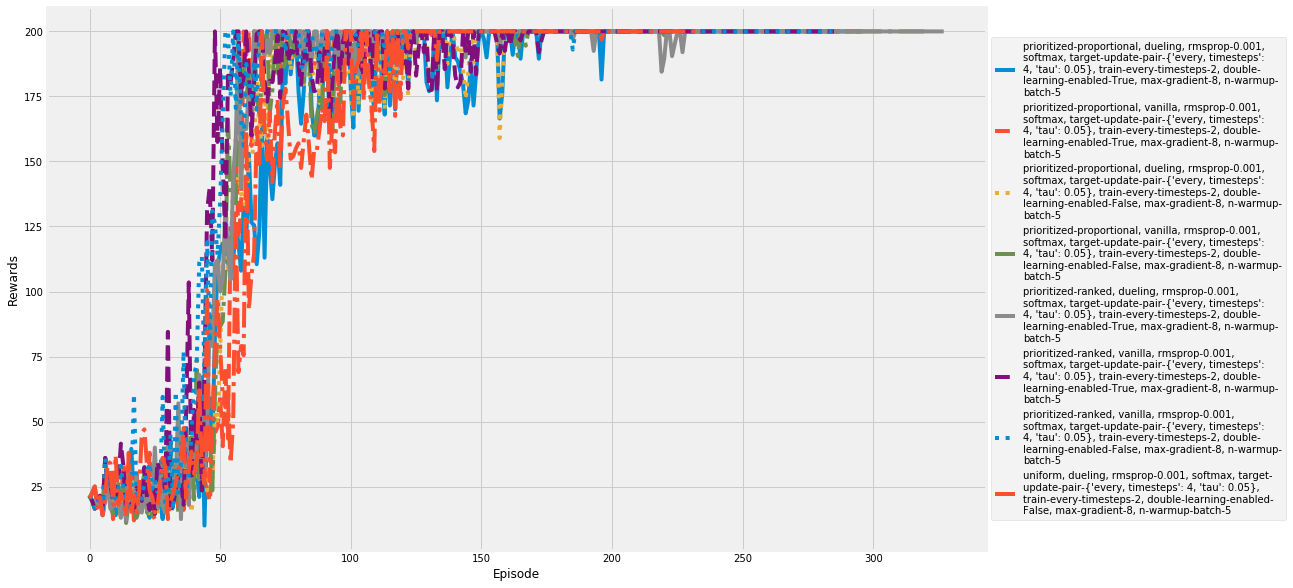

In [20]:
plot_results(training_results, log_scale=False)

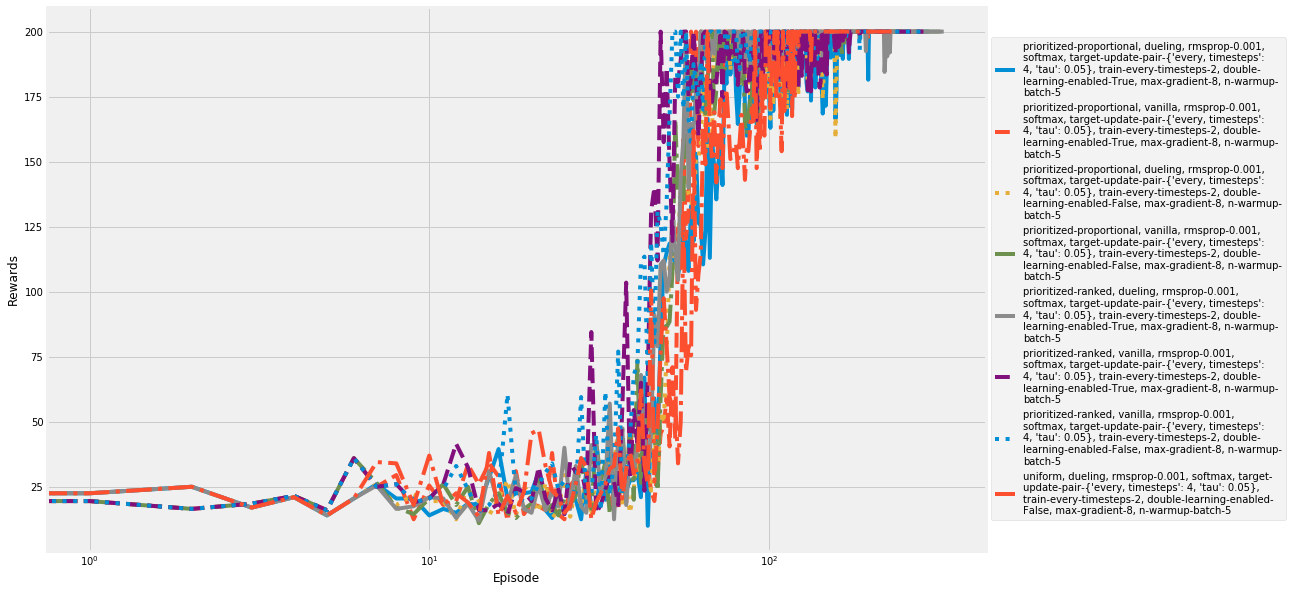

In [21]:
plot_results(training_results, log_scale=True)


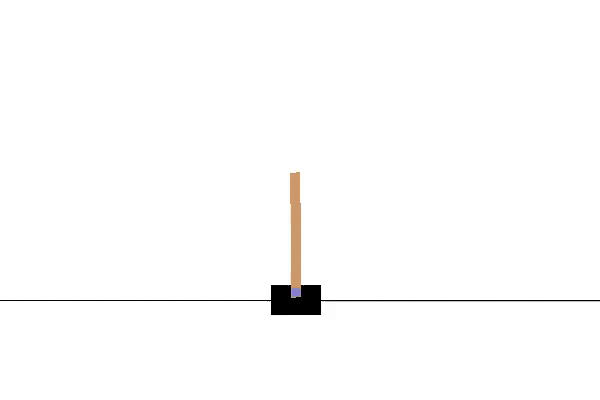
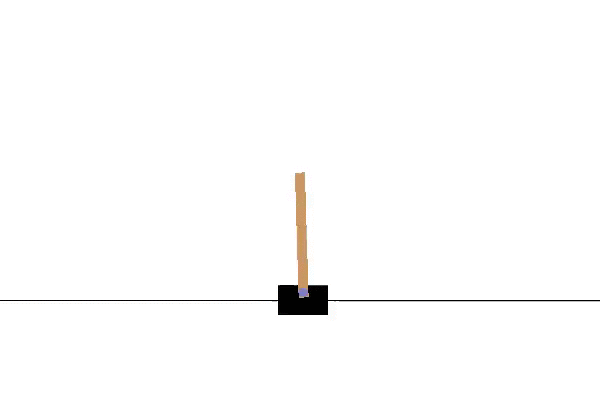
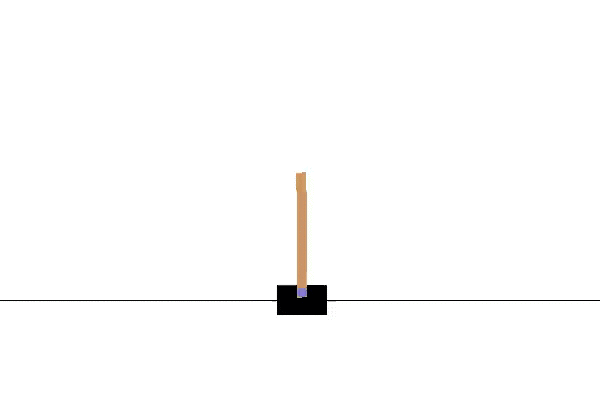
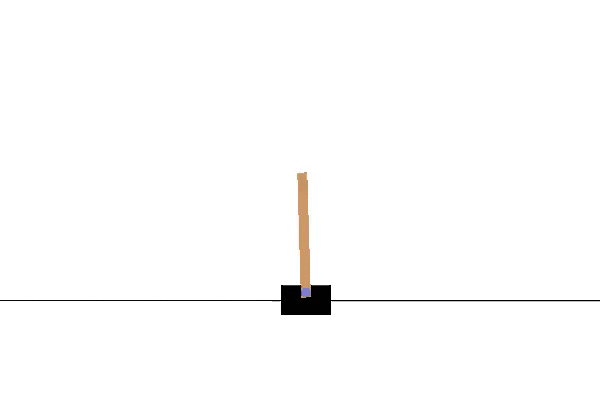
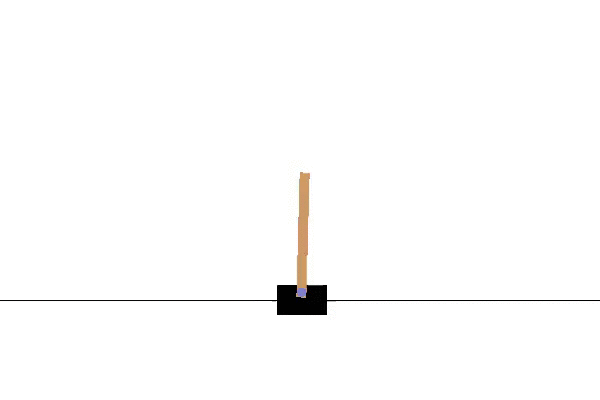

In [22]:
HTML(data=get_gif_html(env_videos=best_training_env.env.videos, title='Training evolution', max_n_videos=5))

In [23]:
print(best_evaluation_env)

best_env(experiment_name="prioritized-proportional_dueling_rmsprop-0.001_softmax_target-update-pair-{'every_timesteps': 4, 'tau': 0.05}_train-every-timesteps-2_double-learning-enabled-True_max-gradient-8_n-warmup-batch-5", env=<Monitor<TimeLimit<CartPoleEnv<CartPole-v1>>>>, mean_reward=500.0, num_episodes=3)


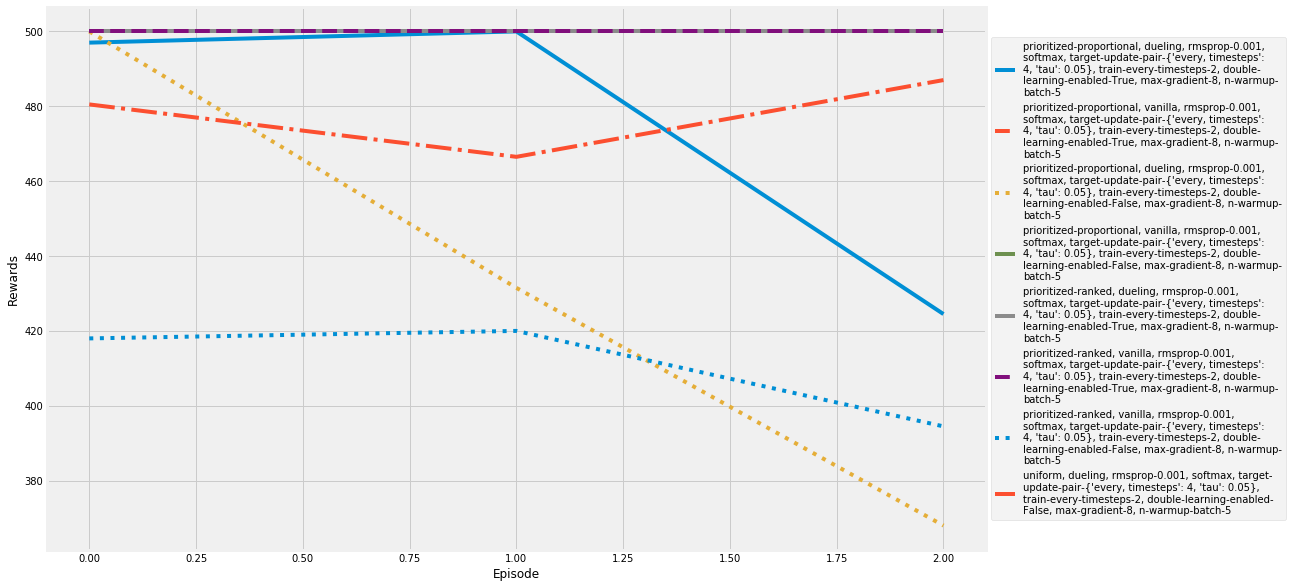

In [24]:
plot_results(evaluation_results, log_scale=False)

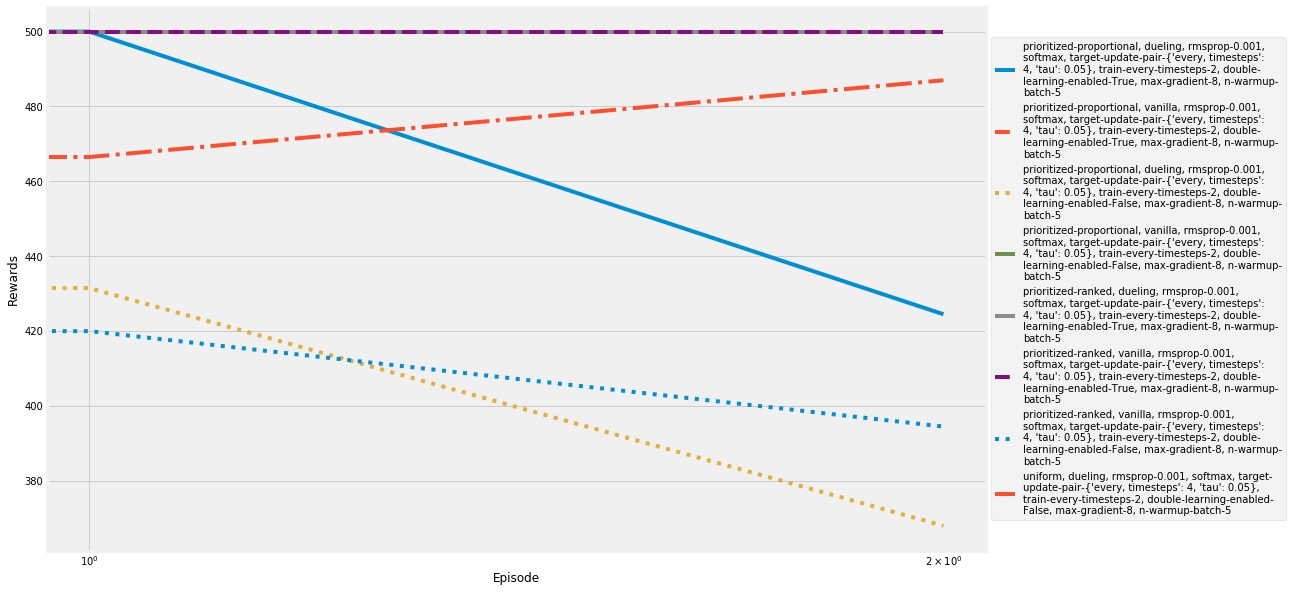

In [25]:
plot_results(evaluation_results, log_scale=True)


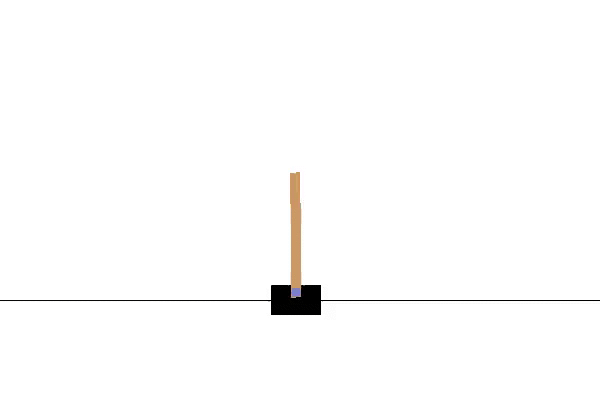
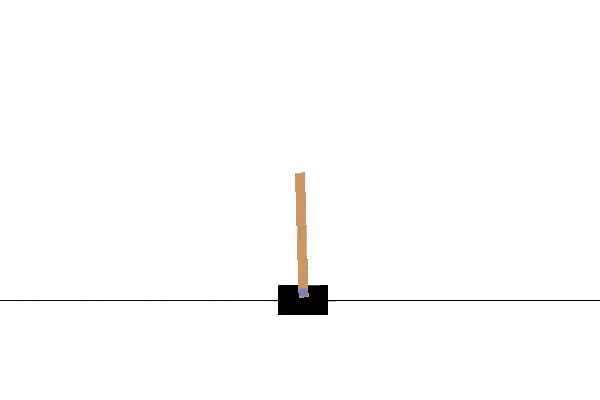

In [26]:
HTML(data=get_gif_html(env_videos=best_evaluation_env.env.videos, title='Evaluation results', max_n_videos=3))